In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [29]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import winsorize

In [3]:
## Import standard packages
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2026
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        price["market_cap"] = price["adjclose"] * price["volume"]
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["year"]>=model_end) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_HIGH.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_LOW.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  2%|█████▏                                                                                                                                                                                                          | 279/11272 [00:07<04:17, 42.65it/s]

'adjclose'


 15%|███████████████████████████████▍                                                                                                                                                                               | 1715/11272 [00:51<04:46, 33.31it/s]

'adjclose'


 34%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 3876/11272 [02:02<03:47, 32.54it/s]

'adjclose'


 37%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 4215/11272 [02:15<04:30, 26.07it/s]

'adjclose'


 37%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 4223/11272 [02:15<03:58, 29.57it/s]

'adjclose'


 45%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 5061/11272 [02:47<03:34, 29.01it/s]

'adjclose'


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 5107/11272 [02:48<02:45, 37.25it/s]

'adjclose'


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 5243/11272 [02:53<02:37, 38.22it/s]

'adjclose'


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 5375/11272 [02:57<03:10, 30.88it/s]

'adjclose'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11272/11272 [06:38<00:00, 28.29it/s]


In [8]:
simulation = pd.concat(prices)
simulation["coefficient_of_variation"] = 1
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'adjclose', 'high', 'low', 'volume', 'ticker', 'market_cap',
       'year', 'month', 'quarter', 'week', 'day', 'weekday', 'adjclose_test',
       'high_test', 'low_test', 'volume_test', 'standard_dev', 'next_close',
       'next_high', 'next_low', 'optimal', 'adr', 'sma', 'sma_corr', 'ema',
       'ema_corr', 'bollinger_upper', 'bollinger_lower', 'momentum', 'roc',
       'williams_r', 'obv', 'vwap', 'market_impact', 'atr',
       'coefficient_of_variation'],
      dtype='object')

In [62]:
results = []
for min_price in tqdm([0.01, 0.1, 1]):
    for max_price in [0.1, 1, 10]:
        for min_market_cap in [10000, 100000, 1000000]:
            for max_market_cap in [100000, 1000000, 10000000]:
                result = {
                        "min_price": min_price,
                        "max_price": max_price,
                        "min_market_cap": min_market_cap,
                        "max_market_cap": max_market_cap
                    }
                if max_price > min_price and max_market_cap > min_market_cap:
                    # Filter simulation data
                    iteration_data = simulation[
                        (simulation["adjclose"] >= min_price) &
                        (simulation["adjclose"] <= max_price) &
                        (simulation["market_cap"] >= min_market_cap) &
                        (simulation["market_cap"] <= max_market_cap)
                    ].copy()
                    if iteration_data.index.size < 10 or "optimal" not in iteration_data.columns:
                        print(iteration_data.index.size)
                        break

                    for col in Indicator:
                        metric = col.label
                        if metric != "optimal":
                            try:
                                corr = iteration_data[[metric, "optimal"]].corr().iloc[0, 1]            
                                metric_result = result.copy()
                                metric_result["metric"] = metric
                                metric_result["corr"] = corr
                                results.append(metric_result)
                            except Exception as e:
                                print(str(e))
                                break  # skip if correlation can't be computed

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.85s/it]


In [63]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Optional: sort by absolute correlation
results_df["abs_corr"] = results_df["corr"].abs()
results_df = results_df.sort_values(by="abs_corr", ascending=False)

In [87]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                member.label for member in Indicator
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[0.1,1,10,100]
                                                            ,min_prices=[0.01,0.1,1,10]
                                                            ,max_market_caps = [1000000]
                                                            ,min_market_caps = [100000]
                                                            ,stoplosses=[1]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "day" and "blacklist" in portfolio.selection_type.label \
        and portfolio.allocation_type.label == "risk" \
        and portfolio.ranking_metric != "optimal" \
        and portfolio.position_type.label == "long" and ("standard_dev" in portfolio.grouping_type.value) \
        and portfolio.max_price > portfolio.min_price:
        filtered_portfolios.append(portfolio)

In [88]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        trades = p.additional_date_columns(trades)
        trades = trades.groupby("weekday").agg({"date":"last","weighted_return":"mean","return":"mean"}).reset_index().sort_values("date")
        trades["date"] = trades.apply(lambda row: datetime.strptime(f"{2025} {10} {row['weekday']+1}", "%Y %W %u"), axis=1)
        trades = p.additional_date_columns(trades)
        trades.sort_values("date")
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [1:22:01<00:00, 17.58s/it]


In [89]:
a = pd.DataFrame(analysises)

In [94]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","max_market_cap","min_market_cap","timeframe","selection_percentage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,stoploss,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
250,market_impact,long,STANDARD_DEV,bottom_blacklist,risk,1,1,0.1,0.01,1,0.997711,1.657290,0.964077,46.696431,0.021366,-0.151782,0.032697,-0.099182
120,bollinger_lower,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.946872,1.586384,0.957738,30.711081,0.030832,-1.754116,0.040528,-1.334437
60,ema,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.950222,1.545859,0.955237,28.400849,0.033458,-1.516317,0.042656,-1.189331
20,sma,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.950222,1.545859,0.955237,28.400849,0.033458,-1.516317,0.042656,-1.189331
100,bollinger_upper,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.950222,1.545859,0.955237,28.400849,0.033458,-1.516317,0.042656,-1.189331
80,ema_corr,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.946342,1.531512,0.951818,32.635530,0.028997,-1.883339,0.038238,-1.428193
40,sma_corr,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.946342,1.531512,0.951818,32.635530,0.028997,-1.883339,0.038238,-1.428193
0,adr,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.939511,1.515127,0.959422,30.953081,0.030353,-2.024292,0.037890,-1.621604
140,momentum,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.931469,1.506337,0.959422,28.871779,0.032262,-2.153746,0.038647,-1.797953
200,obv,long,STANDARD_DEV,top_blacklist,risk,1,1,0.1,0.01,1,0.942365,1.489434,0.954510,38.798401,0.024289,-2.412179,0.033917,-1.727401


In [91]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades).sort_values("date")

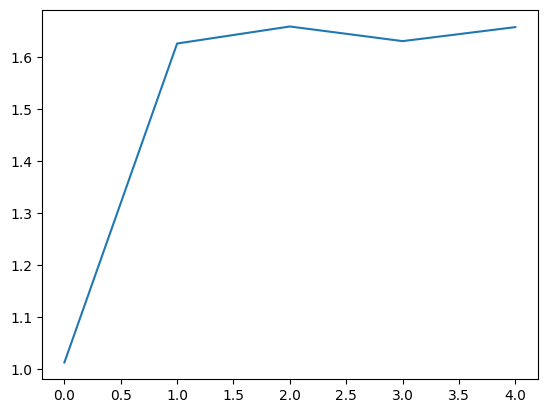

In [92]:
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)
averaged_portfolio = portfolio.groupby("weekday").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()

In [93]:
orivault.connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()